# Arbitrum test strategy

- This is BTC-USD trading pair strategy
- We use alternative price feed taken from Binance to double check the strategy

In [1]:
import os

print(f"Working at {os.getcwd()}")

Working at /Users/moo/code/executor/trade-executor/notebooks


In [2]:

import pandas as pd
import numpy as np
import datetime

import pandas_ta as ta

from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.trade_analyser import build_trade_analysis
import logging
from tradeexecutor.analysis.advanced_metrics import (
    visualise_advanced_metrics,
    AdvancedMetricsMode,
)


from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.strategy.reserve_currency import ReserveCurrency
from tradeexecutor.strategy.strategy_type import StrategyType
from tradeexecutor.strategy.trading_strategy_universe import (
    load_pair_data_for_single_exchange,
    TradingStrategyUniverse,
)

from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

TRADING_STRATEGY_ENGINE_VERSION = "0.2"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# We trade on Polygon
CHAIN_ID = ChainId.polygon

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc_poly

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m5

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Which trading pair we are backtesting on
# (Might be different from the live trading pair)
# https://tradingstrategy.ai/trading-view/polygon/quickswap/eth-usdc
TRADING_PAIR = (ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005)


def plot(state, timestamp, indicators):
    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(
        timestamp,
        "SMA Long",
        PlotKind.technical_indicator_on_price,
        indicators["sma_long"],
        colour="darkblue",
    )
    visualisation.plot_indicator(
        timestamp,
        "SMA Short",
        PlotKind.technical_indicator_on_price,
        indicators["sma_short"],
        colour="darkblue",
    )

    visualisation.plot_indicator(
        timestamp,
        "RSI",
        PlotKind.technical_indicator_detached,
        indicators["rsi"],
        colour="#003300",
    )


# ma_long = 123
# ma_short = 11
# rsi_cutt = 13
# atr_distance = 2.5

# ma_long = 149
# ma_short = 49
# rsi_cutt = 15
# atr_distance = 2

# ma_long = 112
# ma_short = 6
# rsi_cutt = 8
# atr_distance = 2

ma_long = 526
ma_short = 6
rsi_cutt = 100
atr_distance = 2

# Expected 5.28


def get_signals(candles):
    close = candles["close"].iloc[-1]
    low = candles["low"].iloc[-1]

    # Calculate indicators
    sma_short = ta.sma(candles["close"], length=ma_short)
    sma_short = ta.sma(candles["close"], length=ma_short).iloc[-1]
    sma_long = ta.sma(candles["close"], length=ma_long).iloc[-1]
    rsi = ta.rsi(candles["close"], length=2).iloc[-1]
    atr = ta.atr(candles["high"], candles["low"], candles["close"], length=14).iloc[-1]

    # Calculate signals

    entry = close <= sma_short and close >= sma_long and rsi <= rsi_cutt
    exit = close > sma_short
    sl = low - atr * atr_distance
    sl_pct = float(round(sl / candles["open"].iloc[-1], 6))

    indicators = {
        "sma_short": sma_short,
        "sma_long": sma_long,
        "rsi": rsi,
        "atr": atr,
    }
    return entry, exit, sl, sl_pct, indicators


def calculate_size(state, close):
    cash = state.portfolio.get_current_cash()
    return cash * 0.99


current_sl = np.inf


def decide_trades(timestamp, universe, state, pricing_model, cycle_debug_data):
    # The pair we are trading
    trades = []

    pair = universe.pairs.get_single()

    candles: pd.DataFrame = universe.candles.get_single_pair_data(
        timestamp, sample_count=ma_long
    )

    if len(candles) < ma_long:
        # Backtest starting.
        # By default get_single_pair_data() returns the candles prior to the `timestamp`,
        # the behavior can be changed with get_single_pair_data(allow_current=True).
        # At the start of the backtest, we do not have any previous candle available yet,
        # so we cannot ask the the close price.
        return trades

    current_price = candles["close"].iloc[-1]

    entry, exit, sl, sl_pct, indicators = get_signals(candles)
    global current_sl

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    buy_amount = calculate_size(state, current_price)

    if not position_manager.is_any_open():
        if entry:
            # print(sl)
            # sl = 0.98
            current_sl = sl
            trades += position_manager.open_1x_long(pair, buy_amount)
            # trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=sl_pct)
    else:
        if exit:
            current_sl = np.inf
            trades += position_manager.close_all()
        # elif current_price < current_sl:
        #     current_sl = np.inf
        #     trades += position_manager.close_all()

    plot(state, timestamp, indicators)

    return trades


# def create_trading_universe(
#     client: Client,
#     trading_pair,
#     start_at,
#     end_at,
#     execution_context,
#     universe_options,
#     reserve_currency,
#     candle_time_bucket=TimeBucket.h4,
#     stop_loss_time_bucket=TimeBucket.h1,
# ) -> TradingStrategyUniverse:
#     assert (
#         not execution_context.mode.is_live_trading()
#     ), f"Only strategy backtesting supported, got {execution_context.mode}"
#
#     # Load data for our trading pair whitelist
#     dataset = load_partial_data(
#         client=client,
#         time_bucket=candle_time_bucket,
#         pairs=trading_pair,
#         execution_context=execution_context,
#         universe_options=universe_options,
#         stop_loss_time_bucket=stop_loss_time_bucket,
#         start_at=start_at,
#         end_at=end_at,
#     )
#
#     # Filter down the dataset to the pairs we specified
#     universe = TradingStrategyUniverse.create_multichain_universe_by_pair_descriptions(
#         dataset,
#         trading_pair,
#         reserve_token_symbol=reserve_currency,
#     )
#
#     return universe
def create_trading_universe(
    ts: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
):
    assert isinstance(
        client, Client
    ), f"Looks like we are not running on the real data. Got: {client}"

    # Download live data from the oracle
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,
        universe_options=universe_options,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

In [3]:
import os
from pathlib import Path
from tradeexecutor.strategy.pandas_trader.alternative_market_data import load_pair_candles_from_parquet, replace_candles

# trading_pair=[
#     (ChainId.arbitrum, "uniswap-v3", "WBTC", "USDC", 0.0005),
#     # (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
# ],
cycle_duration = CycleDuration.cycle_1h
initial_deposit = 10_000

reserve_currency = ReserveCurrency.usdc
trade_routing = TradeRouting.uniswap_v3_usdc_poly

#
# Load trading universe with DEX data
#
client = Client.create_jupyter_client()
universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    ExecutionContext(mode=ExecutionMode.backtesting),
    universe_options=UniverseOptions(),
)

print(os.getcwd())

#
# Replace the DEX price feed with Binance,
#
pair = universe.get_single_pair()
new_candles, stop_loss_candles = load_pair_candles_from_parquet(
    pair,
    Path("../tests/binance-BTCUSDT-1h.parquet").absolute(),
    include_as_trigger_signal=True,
)
replace_candles(universe, new_candles, stop_loss_candles)

# Change strategy backtesting period
# to match Binance data
start_at = datetime.datetime(2018, 1, 1)
end_at = datetime.datetime(2023, 8, 1)
#end_at = datetime.datetime(2018, 3, 1)



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy
/Users/moo/code/executor/trade-executor/notebooks


In [4]:

state, _, debug_dump = run_backtest_inline(
    name="SLS",
    start_at=start_at,
    end_at=end_at,
    client=client,
    cycle_duration=cycle_duration,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=initial_deposit,
    reserve_currency=reserve_currency,
    trade_routing=trade_routing,
    log_level=logging.WARNING,
)

state.write_json_file(Path("arbitrum-btc-usd-sls-binance-data-1h.json"))

  0%|          | 0/176083200 [00:00<?, ?it/s]

In [5]:
trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

#returns = metrics.loc["Cumulative Return"]
#dd = metrics.loc["Max Drawdown"]
# with pd.option_context("display.max_row", None):
#     display(metrics)
print("==========")
# print(f"Total return: {returns['Strategy']}")
# print(f"Max Drawdown: {dd['Strategy']}")

analysis = build_trade_analysis(state.portfolio)

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

Backtesting completed, backtested strategy made 6404 trades


,0
Trading period length,2015 days 21 hours
Return %,-73.77%
Annualised return %,-13.36%
Cash at start,"$10,000.00"
Value at end,"$2,623.07"
Trade volume,"$43,419,628.55"
Position win percent,64.62%
Total positions,3202
Won positions,2069
Lost positions,1133


# Equity curve

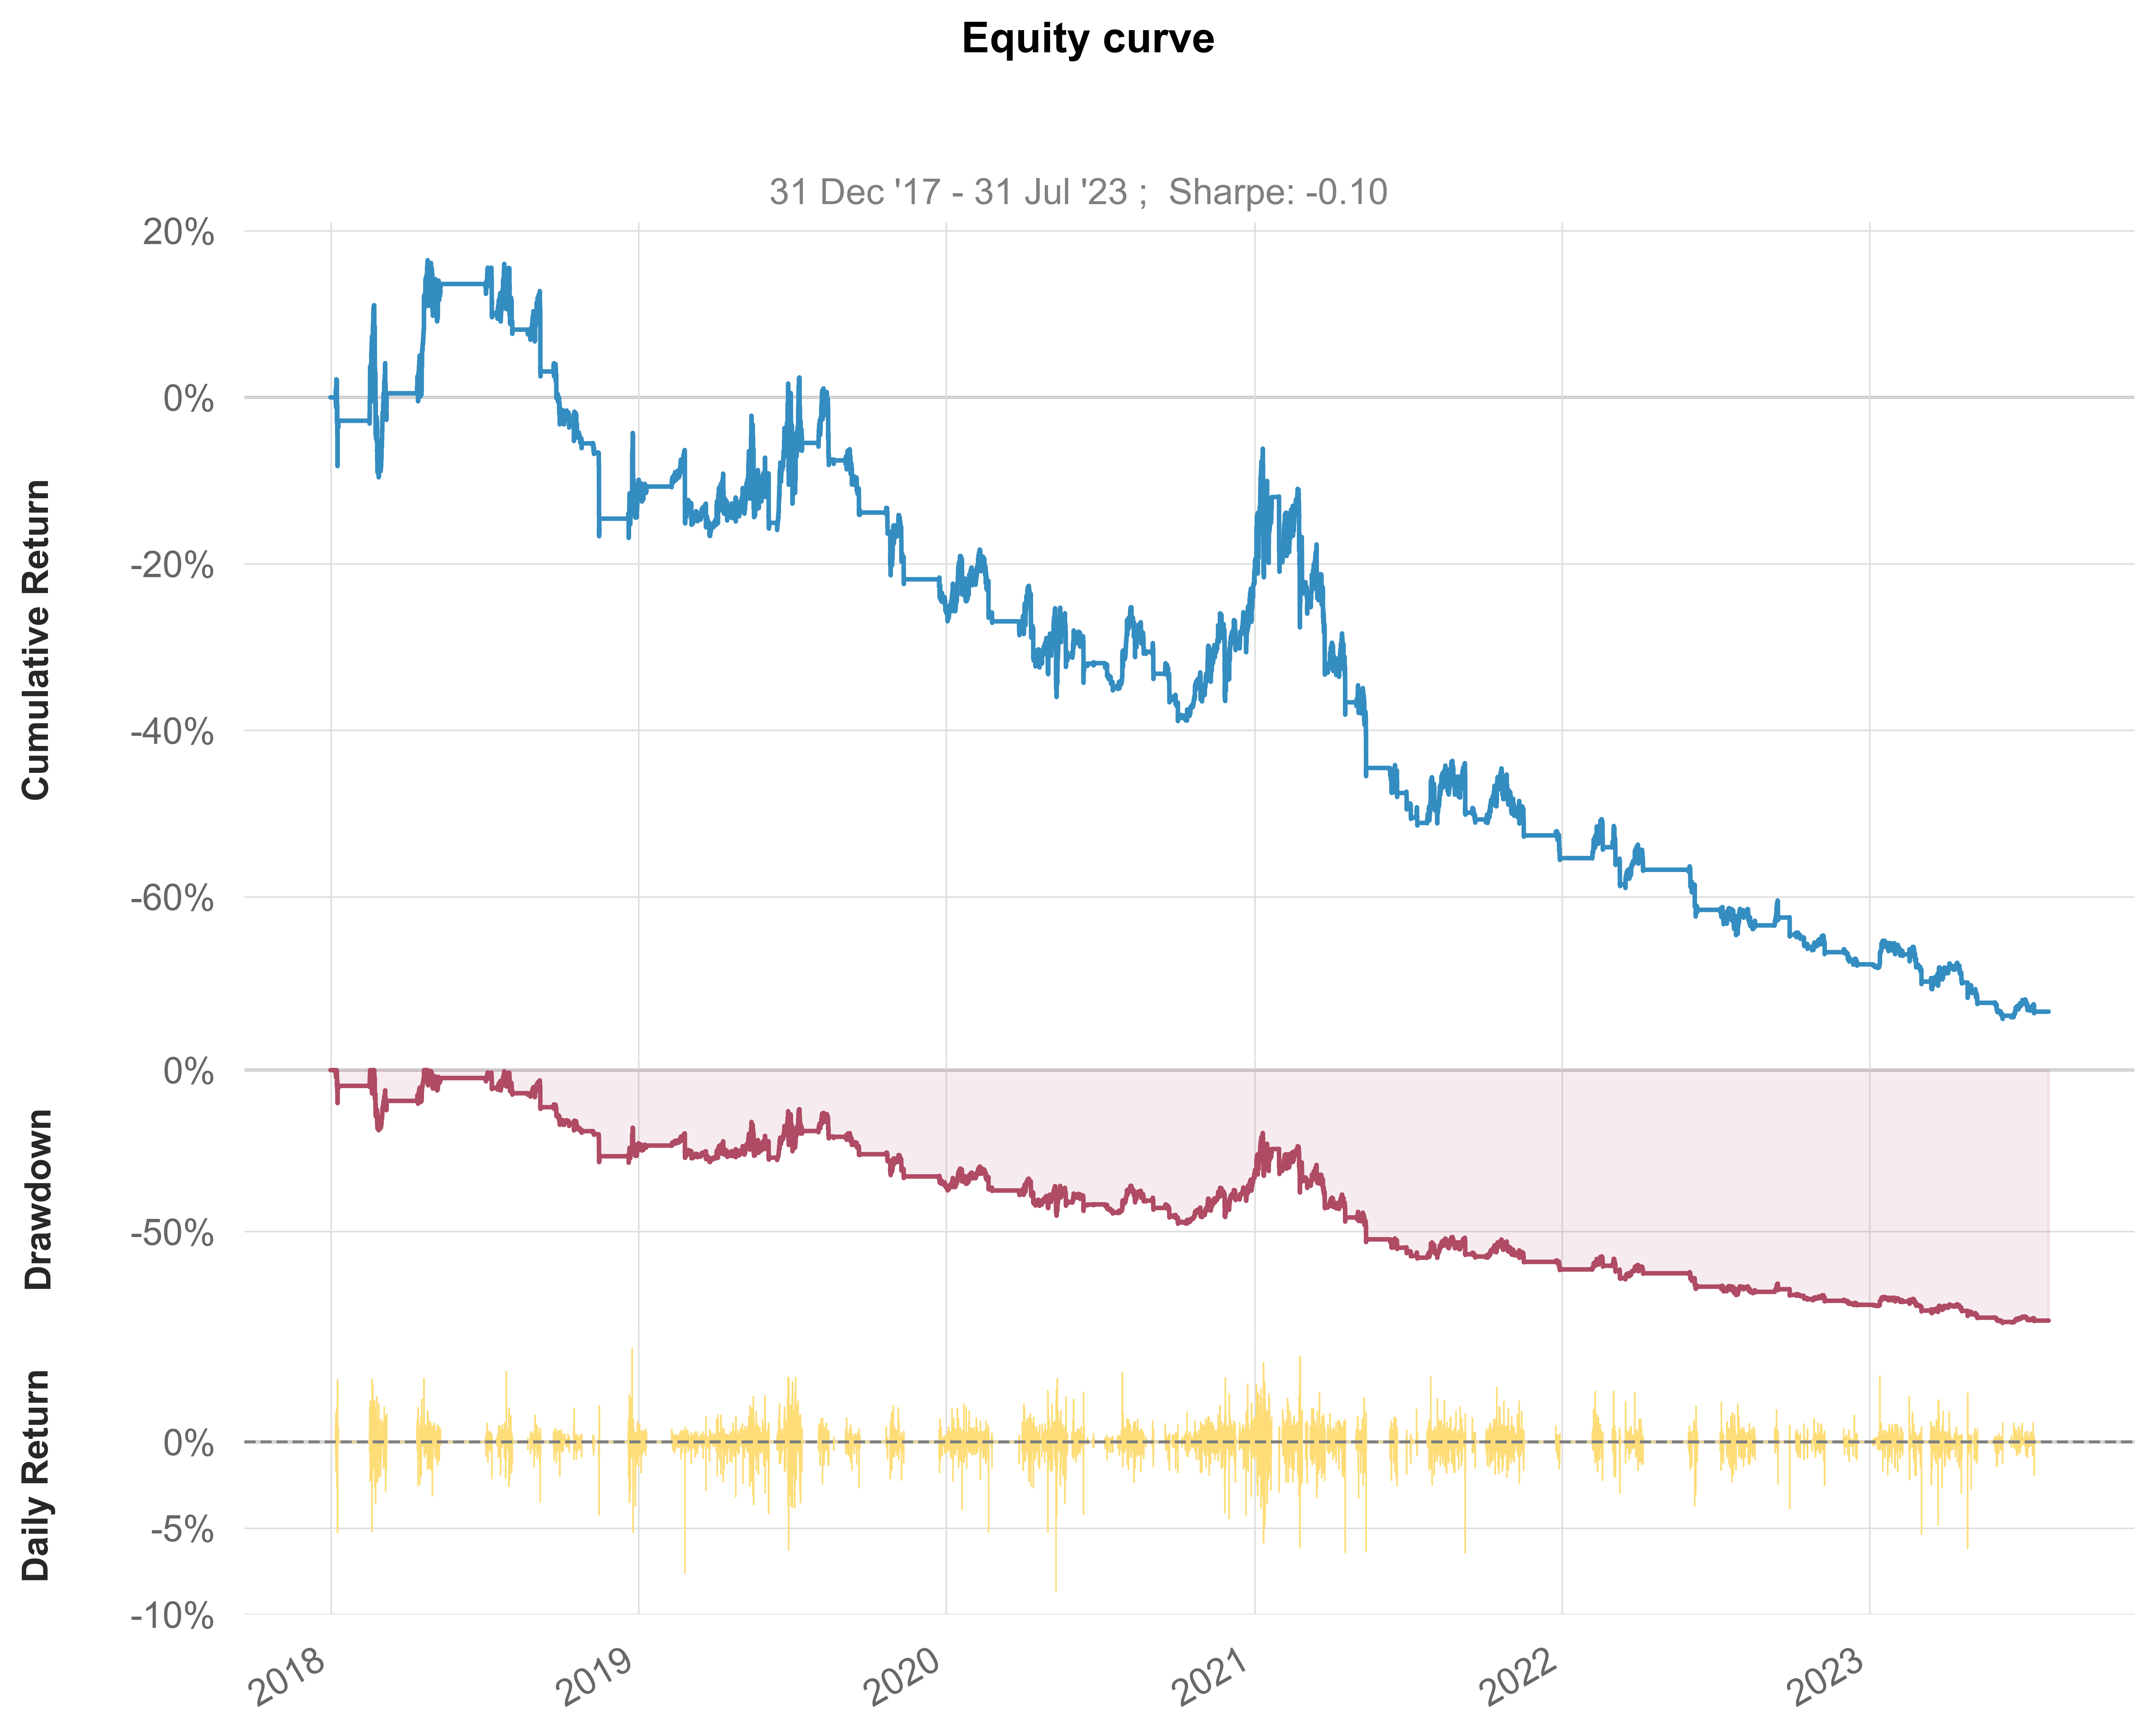

In [6]:
from tradeexecutor.visual.equity_curve import visualise_equity_curve

visualise_equity_curve(returns)

# Entry and exit timeline

In [7]:
from tradeexecutor.analysis.single_pair import expand_entries_and_exits

df = expand_entries_and_exits(state)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(df)

,Entry,Entry mid price,Exit,Exit mid price,PnL,Vol USD,Vol WBTC,LP fee USD,Portfolio size
2018-01-06 03:00:00,2018-01-06 03:00:00,16505.04,2018-01-06 11:00:00,16690.20,101.056017,19901.056017,1.199034,9.953030,10000.000000
2018-01-06 12:00:00,2018-01-06 12:00:00,16505.16,2018-01-06 16:00:00,16550.04,17.169394,20017.260307,1.211142,10.011136,10101.056017
2018-01-06 22:00:00,2018-01-06 22:00:00,16790.99,2018-01-06 23:00:00,16975.01,99.659511,20133.745824,1.192549,10.069403,10118.225411
2018-01-07 03:00:00,2018-01-07 03:00:00,16742.94,2018-01-07 08:00:00,16747.00,-7.660142,20223.752002,1.207751,10.114404,10217.884922
2018-01-07 12:00:00,2018-01-07 12:00:00,16611.00,2018-01-07 21:00:00,16145.01,-293.383794,19922.861269,1.216431,9.963886,10210.224779
2018-01-08 00:00:00,2018-01-08 00:00:00,16218.85,2018-01-08 08:00:00,15864.99,-223.798916,19411.546235,1.210045,9.708173,9916.840985
2018-01-08 09:00:00,2018-01-08 09:00:00,15471.00,2018-01-08 12:00:00,15414.00,-44.911053,19147.312243,1.239909,9.576045,9693.042069
2018-01-09 08:00:00,2018-01-09 08:00:00,15062.28,2018-01-09 09:00:00,15190.56,71.719768,19175.019179,1.267654,9.589917,9648.131016
2018-02-15 10:00:00,2018-02-15 10:00:00,9585.07,2018-02-15 15:00:00,9836.00,242.044245,19487.348796,2.006838,9.746142,9719.850784
2018-02-15 22:00:00,2018-02-15 22:00:00,9873.25,2018-02-15 23:00:00,10062.95,179.442410,19903.994566,1.996779,9.954509,9961.895028
